# Image Inference using Pre-Trained Model on HopsFS Example


To run this notebook you must first install the following libraries in your project's conda environment (in addition to the base libraries):

- Pillow
- Matplotlib

Moreover, the notebook assumes that you have access to the ImageNet dataset, this can either be uploaded to your project or shared from another project.

You also need access to an internet connection so that the pre-trained model can be downloaded.

## Imports

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from hops import experiment
from hops import tensorboard
from hops import featurestore
from hops import hdfs
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from PIL import Image
import numpy as np
from tensorflow.keras.models import load_model
import pydoop.hdfs as pydoop

In [5]:
%%local
import matplotlib.pyplot as plt
import tensorflow as tf
import pydoop.hdfs as pydoop
from hops import hdfs

## Constants

In [6]:
HEIGHT =224
WIDTH = 224
CHANNELS = 3
INPUT_SHAPE = 12288
NUM_CLASSES = 1000
SAMPLE_IMAGE_DIR = pydoop.path.abspath(hdfs.project_path("labs") + "/imagenet_2016/ILSVRC2016_CLS-LOC/ILSVRC/Data/CLS-LOC/train/n03617480/")
SAMPLE_IMAGE_NAME = "n03617480_28686.JPEG"
SAMPLE_IMAGE_PATH = SAMPLE_IMAGE_DIR + SAMPLE_IMAGE_NAME
MODEL_NAME = "resnet_imagenet.h5"

In [7]:
%%local
HEIGHT =224
WIDTH = 224
CHANNELS = 3
INPUT_SHAPE = 12288
NUM_CLASSES = 1000
SAMPLE_IMAGE_DIR = pydoop.path.abspath(hdfs.project_path("labs") + "/imagenet_2016/ILSVRC2016_CLS-LOC/ILSVRC/Data/CLS-LOC/train/n03617480/")
SAMPLE_IMAGE_NAME = "n03617480_28686.JPEG"
SAMPLE_IMAGE_PATH = SAMPLE_IMAGE_DIR + SAMPLE_IMAGE_NAME
MODEL_NAME = "resnet_imagenet.h5"

## Load Pre-Trained ResNet50 Model Trained on ImageNet from Keras.applications

In [8]:
def define_model():
    """
    Defines the model to use for image classification
    
    Returns:
           ResNet50 model
    """
    model = ResNet50(weights="imagenet", input_shape=(HEIGHT, WIDTH, CHANNELS), classes=NUM_CLASSES)
    return model

## Save Pre-Trained model to HopsFS

In [9]:
def save_model(model):
    """
    Save Pre-Trained ImageNet model to HDFS
    
    Args:
         :model: the pre-trained model with weights trained on imagenet
    Returns:
          The HDFS path where it is saved
    """
    # save trained model
    model.save(MODEL_NAME) #Keras can't save to HDFS in the current version so save to local fs first
    hdfs.copy_to_hdfs(MODEL_NAME, hdfs.project_path() + "Resources/", overwrite=True) # copy from local fs to hdfs
    model_hdfs_path = hdfs.project_path() + "Resources/" + MODEL_NAME
    return model_hdfs_path

In [10]:
hdfs_model_path = save_model(define_model())

102858752/102853048 [==============================] - 26s 0us/step

In [11]:
hdfs_model_path

'hdfs://10.0.104.196:8020/Projects/EndToEndV2/Resources/resnet_imagenet.h5'

## Test Inference

#### Copy Trained Model and Sample Image to Local Directory on the Spark Driver

In [12]:
local_model_path = hdfs.copy_to_local(hdfs_model_path, "", overwrite=True) + MODEL_NAME

In [13]:
local_sample_image_path = hdfs.copy_to_local(SAMPLE_IMAGE_PATH, "", overwrite=True) + SAMPLE_IMAGE_NAME

#### Load Saved Model from Local Directory using Keras

In [14]:
model = load_model(MODEL_NAME)

#### Read Sample Image from Local Dir and PreProcess It Using Keras

In [15]:
img = image.load_img(local_sample_image_path, target_size=(HEIGHT, WIDTH))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

#### Perform Inference on the Sample Image using the Pre-Trained Model

In [16]:
predictions = model.predict(x)

#### Decode Predictions

In [17]:
decoded_predictions = decode_predictions(predictions, top=3)

In [18]:
print("Top 1 Prediction: {}".format(decoded_predictions[0][0]))

Top 1 Prediction: ('n03617480', 'kimono', 0.9996618)

In [19]:
print("Top 2 Prediction: {}".format(decoded_predictions[0][1]))

Top 2 Prediction: ('n02730930', 'apron', 0.0003097311)

In [20]:
print("Top 3 Prediction: {}".format(decoded_predictions[0][2]))

Top 3 Prediction: ('n03026506', 'Christmas_stocking', 3.92196e-06)

#### Verify Prediction by Comparing it to the Actual Image

To plot we must use %%local environment, since we can't plot directly from the spark application as it is running in the cluster without a DISPLAY attached.

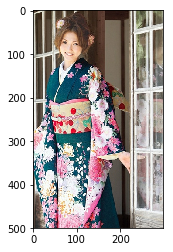

In [21]:
%%local
%matplotlib inline 
with tf.Session() as sess:
    sample_img = tf.image.decode_jpeg(tf.read_file(SAMPLE_IMAGE_PATH)).eval()
    plt.imshow(sample_img)
    plt.show()